# Analyse Transformer Results

18th May - Notebook for looking at the predictions from the transformer naively predicting aflow strings from SMILES strings.

Accuracy

In [54]:
from typing import List
import pandas as pd

VALID_BRAVAIS_LATTICES = ['aP', 'mP', 'mS', 'mA', 'mB', 'mC','oP', 'oS', 'oF', 'oI', 'tP', 'tI', 'hP','hR','cP', 'cF','cI']


def get_rank(row, base, max_rank, tgt_column='target'):
    for i in range(1, max_rank+1):
        if row[tgt_column] == row['{}{}'.format(base, i)]:
            return i
    return 0

def read_targets(targets:str = 'targets.txt',
                 ignore_last_number: bool = False):
    if ignore_last_number:
        with open(targets, 'r') as f:
            targets = [''.join(line.strip().split(' ')[:-1])
                       for line in f.readlines()]
    else:
        with open(targets, 'r') as f:
            targets = [''.join(line.strip().split(' '))
                       for line in f.readlines()]
            
    return targets

def read_preds(preds:str = 'predictions.txt',
               beam_size:int = 5,
              ignore_last_number: bool = False):
    
    predictions = [[] for i in range(beam_size)]

    with open(preds, 'r') as f:

        if ignore_last_number:
            for i, line in enumerate(f.readlines()):

                predictions[i % beam_size].append(
                    ''.join(line.strip().split(' ')[:-1]))
        else:
            for i, line in enumerate(f.readlines()):

                predictions[i % beam_size].append(
                    ''.join(line.strip().split(' ')))
                
    return predictions

def score_accuracy(targets:List, predictions:List, beam_size:int = 5):
    test_df = pd.DataFrame(targets)
    test_df.columns = ['target']
    
    for i, preds in enumerate(predictions):
        test_df['prediction_{}'.format(i + 1)] = preds

    test_df['rank'] = test_df.apply(lambda row: get_rank(
        row, 'prediction_', beam_size), axis=1)

    correct = 0
    for i in range(1, beam_size+1):
        correct += (test_df['rank'] == i).sum()

        print('Top-{}: {:.1f}%'.format(i, correct / len(test_df) * 100))
    return test_df

def read_bravais(aflow_string):
    return aflow_string.split(':')[1][:2]

def score_bravais(targets:List, predictions:List, beam_size:int = 5):
    test_df = pd.DataFrame(targets)
    test_df.columns = ['target']
    test_df['bravais'] = test_df.target.apply(read_bravais)
    print(test_df.bravais.value_counts())
    
    for i, preds in enumerate(predictions):
        test_df[f'prediction_{i+1}'] = preds
        test_df[f'bravais_{i+1}'] = test_df[f'prediction_{i+1}'].apply(read_bravais)
        
    test_df['rank'] = test_df.apply(lambda row: get_rank(
        row, 'bravais_', beam_size, tgt_column='bravais'), axis=1)

    correct = 0
    for i in range(1, beam_size+1):
        correct += (test_df['rank'] == i).sum()
        valid = len(test_df[test_df[f'bravais_{i}'].isin(VALID_BRAVAIS_LATTICES)])
        print(f'Top-{i}: {100*correct/len(test_df):.1f}%, valid bravais lattices: {100*valid/len(test_df):.1f}%')
    return test_df

def score_predictions(beam_size:int = 5,
                      tgt_path:str = 'targets.txt',
                      pred_path:str = 'predictions.txt',
                      ignore_last_number: bool = False,
                      bravais:bool = False):
    
    targets = read_targets(tgt_path, ignore_last_number)
    with open(pred_path, 'r') as f:
        targets = targets[:int(len(f.readlines())/beam_size)]
    print(f'Number of datapoints in test set: {len(targets)}')

    predictions = read_preds(pred_path, beam_size, ignore_last_number)
    
    if bravais:
        test_df = score_bravais(targets, predictions, beam_size)
    else:
        test_df = score_accuracy(targets, predictions, beam_size)
    return test_df


Ignoring last number (number of atoms in unit cell)

In [28]:
transformer_preds = '/Users/williammccorkindale/ml_physics/smi2wyck/data/smi2protopear/pred_step_20000.txt'

targets = '/Users/williammccorkindale/ml_physics/smi2wyck/data/smi2protopear/tgt-test.csv'
score_predictions(beam_size=5, tgt_path=targets, pred_path=transformer_preds, ignore_last_number=True)

Number of datapoints in test set: 28310
Top-1: 17.8%
Top-2: 27.2%
Top-3: 32.2%
Top-4: 36.6%
Top-5: 39.7%


,target,prediction_1,prediction_2,prediction_3,prediction_4,prediction_5,rank
0,A13B18C9:mP,A13B18C9:mP,A7B9C4:mP,A7B10C4:mP,A13B18C9:oP,A13B18C9:aP,1
1,A27B31C3D2E:aP,A28B33C3D2E:mP,A28B33C3D2E:mP,A28B31C3D2E:mP,A29B33C3D2E:mP,A28B31C3D2E:mP,0
2,A17B13CD:mP,A18B15CD:mP,A18B15CD:oP,A17B13CD:mP,A17B13CD:mP,A18B15CD:oP,3
3,A16B15CD2:oP,A17B17CD2:aP,A17B17CD2:mP,A17B17CD2:mP,A17B17CD2:mP,A17B17CD2:oP,0
4,A15B14C3D:mP,A16B16C3D:aP,A16B16C3D:mP,A16B16C3D:mP,A16B15C3D:mP,A32B31C6D2:mP,0
...,...,...,...,...,...,...,...
28305,A9B16C5:oP,A8B13C4:mP,A16B28C10:mP,A16B28C10:mP,A16B28C11:mP,A16B28C10:mP,0
28306,A27B42C4:oP,A7B11C:oP,A7B11C:mP,A27B42C4:oP,A14B22C2:oP,A14B22C2:mP,3
28307,AB45C91D2E8:aP,AB42C76D2E7:mP,AB40C73D2E7:mP,AB42C74D2E7:mP,AB40C74D2E7:mP,AB40C73D2E7:aP,0
28308,A22B22C2D3:mP,A22B22C2D3:mP,A22B22C2D3:mP,A22B22C2D3:oP,A22B22C2D3:aP,A22B22C2D3:mP,1


Including last number

In [29]:
score_predictions(beam_size=5, tgt_path=targets, pred_path=transformer_preds, ignore_last_number=False)

Number of datapoints in test set: 28310
Top-1: 12.8%
Top-2: 20.3%
Top-3: 25.6%
Top-4: 29.7%
Top-5: 32.7%


,target,prediction_1,prediction_2,prediction_3,prediction_4,prediction_5,rank
0,A13B18C9:mP160,A13B18C9:mP164,A7B9C4:mP168,A7B10C4:mP176,A13B18C9:oP328,A13B18C9:aP82,0
1,A27B31C3D2E:aP128,A28B33C3D2E:mP268,A28B33C3D2E:mP272,A28B31C3D2E:mP260,A29B33C3D2E:mP272,A28B31C3D2E:mP256,0
2,A17B13CD:mP128,A18B15CD:mP140,A18B15CD:oP140,A17B13CD:mP132,A17B13CD:mP128,A18B15CD:oP280,4
3,A16B15CD2:oP272,A17B17CD2:aP148,A17B17CD2:mP296,A17B17CD2:mP148,A17B17CD2:mP152,A17B17CD2:oP296,0
4,A15B14C3D:mP132,A16B16C3D:aP144,A16B16C3D:mP296,A16B16C3D:mP288,A16B15C3D:mP280,A32B31C6D2:mP284,0
...,...,...,...,...,...,...,...
28305,A9B16C5:oP840,A8B13C4:mP300,A16B28C10:mP424,A16B28C10:mP440,A16B28C11:mP424,A16B28C10:mP432,0
28306,A27B42C4:oP292,A7B11C:oP304,A7B11C:mP152,A27B42C4:oP292,A14B22C2:oP304,A14B22C2:mP152,3
28307,AB45C91D2E8:aP588,AB42C76D2E7:mP<unk>,AB40C73D2E7:mP<unk>,AB42C74D2E7:mP<unk>,AB40C74D2E7:mP<unk>,AB40C73D2E7:aP<unk>,0
28308,A22B22C2D3:mP196,A22B22C2D3:mP200,A22B22C2D3:mP100,A22B22C2D3:oP200,A22B22C2D3:aP98,A22B22C2D3:mP196,5


Check Bravais Lattices

In [31]:
test_df = score_predictions(beam_size=5, tgt_path=targets, pred_path=transformer_preds, ignore_last_number=False, bravais=True)

Number of datapoints in test set: 28310
mP    14028
oP     6549
aP     6542
mC      407
tP      229
hP      173
oF      118
hR      106
tI      104
oI       36
cP        9
cI        7
cF        2
Name: bravais, dtype: int64
Top-1: 50.1%, valid bravais lattices: 100.0%
Top-2: 64.0%, valid bravais lattices: 100.0%
Top-3: 72.6%, valid bravais lattices: 100.0%
Top-4: 78.8%, valid bravais lattices: 100.0%
Top-5: 82.6%, valid bravais lattices: 100.0%


In [41]:
100*test_df['bravais_1'].value_counts()/len(test_df)

mP    88.346874
oP     7.672201
aP     3.980925
Name: bravais_1, dtype: float64

Text(0.5, 1.0, 'Bravais lattice distribution')

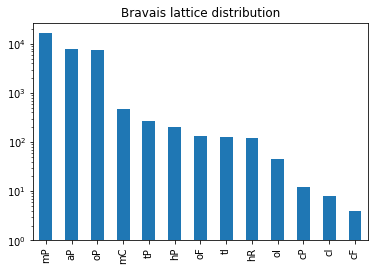

In [52]:
test_df['bravais'].value_counts().plot(kind='bar', log=True).set_title('Bravais lattice distribution')

Results for model trained for 50k steps

In [58]:
transformer_preds = '/Users/williammccorkindale/ml_physics/smi2wyck/data/smi2protopear/pred_step_50000.txt'
score_predictions(beam_size=5, tgt_path=targets, pred_path=transformer_preds, ignore_last_number=True)
score_predictions(beam_size=5, tgt_path=targets, pred_path=transformer_preds, ignore_last_number=False)
test_df = score_predictions(beam_size=5, tgt_path=targets, pred_path=transformer_preds, ignore_last_number=False, bravais=True)

Number of datapoints in test set: 33268
Top-1: 35.8%
Top-2: 55.1%
Top-3: 64.7%
Top-4: 69.6%
Top-5: 71.5%
Number of datapoints in test set: 33268
Top-1: 29.1%
Top-2: 45.6%
Top-3: 55.7%
Top-4: 63.1%
Top-5: 67.1%
Number of datapoints in test set: 33268
mP    16448
aP     7774
oP     7662
mC      466
tP      273
hP      204
oF      132
tI      125
hR      119
oI       44
cP       11
cI        7
cF        3
Name: bravais, dtype: int64
Top-1: 50.6%, valid bravais lattices: 100.0%
Top-2: 75.1%, valid bravais lattices: 100.0%
Top-3: 86.2%, valid bravais lattices: 100.0%
Top-4: 90.5%, valid bravais lattices: 100.0%
Top-5: 92.0%, valid bravais lattices: 100.0%


In [69]:
test_df.drop(['bravais', 'bravais_1', 'bravais_2', 'bravais_3', 'bravais_4', 'bravais_5', 'rank'], axis=1)

,target,prediction_1,prediction_2,prediction_3,prediction_4,prediction_5
0,A13B18C9:mP160,A13B18C9:mP160,A13B18C9:oP320,A13B18C9:aP80,A13B18C9:aP160,A13B18C9:mP320
1,A27B31C3D2E:aP128,A27B31C3D2E:mP256,A27B31C3D2E:aP128,A27B31C3D2E:oP256,A27B31C3D2E:mP128,A27B31C3D2E:oP512
2,A17B13CD:mP128,A17B13CD:mP128,A17B13CD:oP128,A17B13CD:oP256,A17B13CD:mP64,A17B13CD:aP64
3,A16B15CD2:oP272,A16B15CD2:mP272,A16B15CD2:aP136,A16B15CD2:mP136,A16B15CD2:oP272,A16B15CD2:mC272
4,A15B14C3D:mP132,A15B14C3D:mP264,A15B14C3D:aP132,A15B14C3D:mP132,A15B14C3D:aP66,A15B14C3D:oP264
...,...,...,...,...,...,...
33263,A18BC2:oP336,A18B15CD2:aP144,A18B15CD2:mP288,A18B15CD2:aP288,A18B15CD2:mP576,A18B15CD2:oP576
33264,A7B13CD6E:mP112,A7B13CD6E:mP112,A7B13CD6E:oP224,A7B13CD6E:aP56,A14B26C2D13E2:mP110,A7B12CD6E:mP108
33265,A13B24C2D12E:aP52,A13B24C2D12E:mP104,A13B24C2D12E:oP208,A13B24C2D13E:mP102,A13B24C2D13E:oP204,A13B24C2D12E:aP104
33266,A19BC26D5E3:mP216,A19BC26D5E3:mP216,A19BC24D5E3:mP208,A19BC26D5E3:aP108,A19BC24D5E3:aP104,A19BC25D5E3:mP212


In [56]:
100*test_df['bravais_3'].value_counts()/len(test_df)

oP    36.103763
mP    35.352290
aP    28.537934
hP     0.003006
mC     0.003006
Name: bravais_3, dtype: float64